<a href="https://colab.research.google.com/github/zugzvangg/ML_MIPT_4sem/blob/main/TransferLearning/zalando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Transfer Learning на PyTorch и TorchVision


In [64]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import torch.nn as nn
import torch
from torchvision import datasets, models, transforms
from PIL import Image
import torchvision
import time
import os
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics as metrics
import random
from IPython.core.display import display, HTML
from sklearn.metrics.pairwise import cosine_similarity

Все датасеты хранятся на Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Датасет с тегами одежды:

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/zalando_english.csv')

In [4]:
df.head()

,Unnamed: 0,url,descriptions,split
0,0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"short, sexy, summer, sexy, party, yellow dress...",7
1,1,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,blue knee-length ladies dress with white dots ...,6
2,2,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,This product is a dress. It's striped gray and...,2
3,3,https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...,Thigh-length fabric dress in gray with hip poc...,7
4,4,https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...,It is an elegant dark blue medium length dress...,7


Нужные модули nltk:

In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Сперва вытащим из датасета связанные с объектом существительные и прилагательные: 

In [6]:
def nouns(text):
  return [sample.lower() for (sample, position) in nltk.pos_tag(nltk.word_tokenize(text)) if position[:2] == 'NN']

def adjectives(text):
  return [sample.lower() for (sample, position) in nltk.pos_tag(nltk.word_tokenize(text)) if position[:2] == 'JJ']

df['nouns'] = df['descriptions'].apply(lambda v: nouns(v))
df['adjs'] = df['descriptions'].apply(lambda v: adjectives(v))

In [7]:
df.head()

,Unnamed: 0,url,descriptions,split,nouns,adjs
0,0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"short, sexy, summer, sexy, party, yellow dress...",7,"[summer, sexy, party, dress, sleeves, yellow, ...","[short, sexy, yellow, shoulder-free, fabric, y..."
1,1,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,blue knee-length ladies dress with white dots ...,6,"[ladies, dress, dots, pattern, round, neckline...","[blue, knee-length, white, short, white, polka..."
2,2,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,This product is a dress. It's striped gray and...,2,"[product, dress, blue, beach, dress, knees, ro...","[striped, gray, white, light, white, gray, whi..."
3,3,https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...,Thigh-length fabric dress in gray with hip poc...,7,"[thigh-length, fabric, dress, pockets, round, ...","[gray, hip, elbow-length, casual, three-fold, ..."
4,4,https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...,It is an elegant dark blue medium length dress...,7,"[dark, medium, length, dress, sleeves, top, ro...","[elegant, blue, black, figure-hugging, knee-le..."


Найдем самые популярные теги для каждого айтема:

In [8]:
def tags(tags, number):
    tf = TfidfVectorizer(analyzer='word', stop_words='english')
    return np.array(tags)[np.argsort(tf.fit_transform(tags).toarray().sum(axis=1)).flatten()[::-1][:number]]

df['nouns'] = df['nouns'].apply(lambda x: tags(x, 15))
df['adjs'] = df['adjs'].apply(lambda x: tags(x, 15))

In [9]:
df.head()

,Unnamed: 0,url,descriptions,split,nouns,adjs
0,0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"short, sexy, summer, sexy, party, yellow dress...",7,"[knee-length, straps, dress, sexy, party, dres...","[shoulder-free, shoulder-free, wide, v-necklin..."
1,1,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,blue knee-length ladies dress with white dots ...,6,"[knee-length, skirt, height, dress, dots, patt...","[knee-length, knee-length, knee-length, white,..."
2,2,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,This product is a dress. It's striped gray and...,2,"[calf-length, feet, dress, dress, blue, beach,...","[small, white, black, gray, white, knitted, co..."
3,3,https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...,Thigh-length fabric dress in gray with hip poc...,7,"[thigh-length, length, fabric, dress, pockets,...","[half-length, elbow-length, neckline, hip, cas..."
4,4,https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...,It is an elegant dark blue medium length dress...,7,"[knee-length, sleeves, dress, medium, length, ...","[tight-fitting, figure-hugging, knee-length, s..."


Также самые популярные тэги по всем айтемам:

In [10]:
def most_pop(group, num=25):
  val, cnt_of_w = np.unique(np.concatenate(df[group].to_numpy()), return_counts=True)
  return val[np.argpartition(-cnt_of_w, kth=num)[:num]]

Существительные:


In [11]:
print(most_pop("nouns", 30))



['sleeves' 'dress' 'pattern' 'knees' 'straps' 'knee-length' 'neckline'
 'skirt' 'waist' 'round' 'blue' 'length' 'collar' 'v-neck' 'cut' 'belt'
 'sleeveless' 'summer' 'lace' 'mini' 'arms' 'neck' 'shoulders' 'pink'
 'v-neckline' 'shoulder' 'fabric' 'color' 'stripes' 'knee']


Прилагательные:

In [12]:
print(most_pop("adjs", 30))

['light' 'small' 'black' 'wide' 'long' 'blue' 'knee-length' 'white' 'red'
 'gray' 'sleeveless' 'colorful' 'free' 'tight' 'narrow' 'dark'
 'figure-hugging' 'short' 'deep' 'floral' 'half-length' 'large' 'fabric'
 'shoulder-free' 'elegant' 'medium-length' 'green' 'high' 'transparent'
 'straight']


In [13]:
n_cl = most_pop("nouns", 20)
a_cl = most_pop("adjs", 20)
df['nouns'] = df['nouns'].map(lambda v: list(n_cl[np.in1d(n_cl, v)])).values
df['adjs'] = df['adjs'].map(lambda v: list(a_cl[np.in1d(a_cl, v)])).values
df = df[df['nouns'].map(len) >= 1]
df = df[df['adjs'].map(len) >= 1]
df['tags'] = df['nouns'] + df['adjs']




In [14]:
mlb = MultiLabelBinarizer()
Y = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_).to_numpy()

Предварительно картинки пришлось сжать с помощью Pillow, так как не хватало ОЗУ

In [15]:
!unzip /content/drive/MyDrive/Datasets/zalando_compressed.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: zalando_compressed/L4221C0B4-G11@12.jpg  
  inflating: zalando_compressed/L4221C0B5-E11@11.1.jpg  
  inflating: zalando_compressed/L4221C0B6-Q11@12.1.jpg  
  inflating: zalando_compressed/L4221C0B7-K11@2.jpg  
  inflating: zalando_compressed/L4221C0B8-Q11@12.jpg  
  inflating: zalando_compressed/L4221C0B9-Q11@10.jpg  
  inflating: zalando_compressed/L4221C0BA-Q11@10.jpg  
  inflating: zalando_compressed/L4221C0BB-Q11@14.jpg  
  inflating: zalando_compressed/L4221C0BC-Q11@14.jpg  
  inflating: zalando_compressed/L4221C0BD-K11@12.jpg  
  inflating: zalando_compressed/L4221C0BE-Q11@14.jpg  
  inflating: zalando_compressed/L4221C0BF-Q11@11.jpg  
  inflating: zalando_compressed/L4221C0BG-M11@10.jpg  
  inflating: zalando_compressed/L4221C0BH-Q11@22.jpg  
  inflating: zalando_compressed/L4221C0BI-Q11@12.jpg  
  inflating: zalando_compressed/L4221C0BJ-T11@12.1.jpg  
  inflating: zalando_compressed/L4221C0BK-K11@1

In [16]:
image_tensors = []
images = []

transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((100, 100)), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
for i, url in enumerate(df['url'].values):
    img = Image.open(f"/content/zalando_compressed/{url.split('/')[-1]}").convert('RGB')
    images.append(img)
    img_tensor = transforms(img)
    image_tensors.append(img_tensor)

Свой датасет, проходя через который картинки преобразуются

In [65]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = torch.Tensor(targets)
        self.transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomGrayscale(), 
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    transforms.CenterCrop(10),
                                    transforms.RandomPerspective()
                                ])

    def __getitem__(self, index):
        x = self.transform(self.data[index])
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [66]:
x_train, x_test, y_train, y_test = train_test_split(images, Y, test_size=0.3, random_state=42)
train_dataset = MyDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataset = MyDataset(x_test, y_test)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)
image_datasets = {'train': x_train, 'val': x_test}
dataloaders = {'train': dataloader_train, 'val': dataloader_test}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:

class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
        self.featureLayer = self.base_model._modules.get('avgpool')

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def getImageVec(self, img):
        image = img.unsqueeze(0).to(device)
        embedding = torch.zeros(1, 2048, 1, 1)
        def copyData(m, i, o): embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

model = Resnext50(len(mlb.classes_))
model = model.to(device)
model.train()

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

Векторизированные картинки из тензора:

In [69]:
image_vectors = []
for image in image_tensors:
    image_vectors.append(model.getImageVec(image))

Выявим схожие картинки:

In [70]:
similarity_matrix = [];
for i in [random.randint(1, len(image_vectors)) for _ in range(10)]:
    similarity_dict = {}
    for j in range(len(image_vectors)):
        similarity_dict[j] = cosine_similarity([image_vectors[i]], [image_vectors[j]])[0][0]
    similarity_matrix.append(similarity_dict)

similar_images = []
for row in similarity_matrix:
    sorted_list = sorted(row.items(), key=lambda v: v[1], reverse=True)
    similar = []
    for item in sorted_list[0:5]:
        id = item[0]
        similar.append((df.iloc[id]['url'], item[1]))
    similar_images.append({'id': sorted_list[0][0], 'similar': similar})

In [58]:
res = ''
for row in similar_images:
    res += 'similarity:'
    for (url, sim) in row['similar']:
        res += (
        '<figure style="display: inline-block">'
            '<center>'
            f'<img src="{url}" height="100" width="100">'
            f'<figcaption>{round(sim, 3)}</figcaption>' 
            '</center>'
        '</figure>'
        )
    res+='<br/>'

display(HTML(res))

In [100]:
def checkpoint_save(model, epoch):
    f = os.path.join('/content/drive/MyDrive/Datasets/', 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
def calculate_metrics( pred, target, epoch, iteration, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    print("epoch: ", epoch, "iteration: ", iteration)
    print("f1: ", round(metrics.f1_score(y_true=target, y_pred=pred, average='micro'),3), "accuracy:", round(metrics.accuracy_score(target, pred),3))

In [82]:
def after(epoch, iteration, loss_value):
  print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))

In [ ]:
max_epoch_number = 10
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
epoch = 0
iteration = 0
test_freq = 10
save_freq = 1
while True:
    batch_losses = []
    for imgs, targets in dataloaders['train']:
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
        batch_losses.append(batch_loss_value)
        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in dataloaders['train']:
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())
            calculate_metrics(np.array(model_result), np.array(targets), epoch, iteration)
            model.train()
        iteration += 1
    loss_value = np.mean(batch_losses)
    after(epoch, iteration, loss_value)
    if epoch % save_freq == 0:
        checkpoint_save(model, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break

Возьмём модель, сохранённую на 10-й эпохе


In [101]:
model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/Datasets/checkpoint-000010.pth')))

<All keys matched successfully>

In [108]:
def results(model, number_of_images=6, num_of_pr_tags = 5):
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            preds = np.array(model(inputs.to(device)).cpu())[0]
            top = np.sort(preds)[::-1][min(2, len(preds)-1)]
            preds[preds < top] = 0
            preds[preds >= top] = 1
            tags = mlb.inverse_transform(np.array([preds]))[0][:3]
            plt.subplot(2, 3, i + 1)
            plt.title('Predicted tags: ' + ', '.join(map(str, tags)) + '\n' + 'Real tags: ' + ', '.join(mlb.inverse_transform(np.array([labels.to(device).cpu().numpy()[i]]))[0][:num_of_pr_tags]))
            plt.imshow(np.array([0.5, 0.5, 0.5]) * np.array(inputs.to(device).cpu().data[i]).transpose(1, 2, 0) + np.array([0.5, 0.5, 0.5]))
            if i >= number_of_images - 1:
                return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


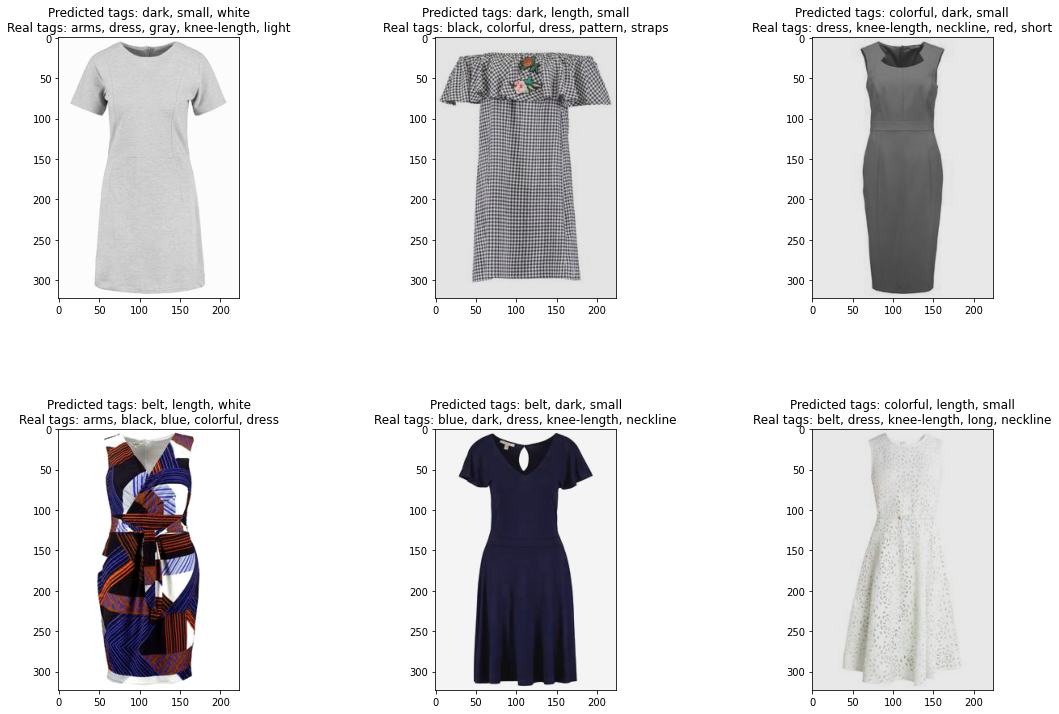

In [110]:
fig, ax = plt.subplots(figsize=(18,12))
plt.subplots_adjust(hspace=.5, wspace=.5)
results(model, number_of_images=6, num_of_pr_tags=5)